In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import json
#import folium

# Est-ce que le sommet est visible ?

### Obtenir les données

Le plus simple est d'utiliser les données SRTM: https://earthexplorer.usgs.gov/  
Ce site web propose une interface de visualisation et de téléchargement des bonnes tuiles.
Mais il y a des trous dans les données, surtout dans la région du Mont-Blanc ... en fait il n'y a pas le Mont-Blanc, ce qui est plutôt gênant ici ...


On trouve sur le wiki de OSM une liste des autres sources SRTM existantes: http://wiki.openstreetmap.org/wiki/SRTM

J'ai finalement utilisé les données de [VIEWFINDER PANORAMAS](http://www.viewfinderpanoramas.org/dem3.html#alps). Elles sont à priori libre pour un usage libre. 

La résolution est de 1 arc-sec (30m), et il n'y a pas de trous.

Rq: Il existe aussi des données européennes mais les fichiers font 2.8Gb...  [EU-DEM](https://www.eea.europa.eu/data-and-maps/data/eu-dem#tab-european-data)

Les tuiles utilisées pour les Alpes sont :  

    N44E005.hgt  N44E006.hgt  N45E005.hgt  N45E006.hgt
    
Elles sont combinées en un fichier unique grâce à la commande suivante :

    gdal_merge.py *.hgt -o merged_1arc.hgt

On obtient cette image :  (je l'ai enregistrée parce que mon ordi freeze quelques minutes pour l'afficher)
![elevation_map_1arc](elevation_map_1arc.png)

### Traiter les données avec Python

Je pensais utiliser `georaster`:  https://pypi.python.org/pypi/georasters/  ... mais il ne s'installe pas (facilement) en virtual env. du fait de la librairie `gdal`

Il y a sur stackoverflow une [solution pour installer GDAL en Virtualenv](https://stackoverflow.com/questions/32066828/install-gdal-in-virtualenvwrapper-environment), qui fonctionne chez moi, en gérant les numéros de versions.

    sudo apt-get install libgdal1i libgdal1-dev libgdal-dev
    pip install pygdal==2.1.3.3

http://sherrytowers.com/2014/04/13/archeoastronomy-calculating-the-horizon-profile-using-online-us-geographic-survey-data/

In [3]:
from osgeo import gdal

In [280]:
# Chargement du fichier

filename = 'elevation_data/viewfinderdata/merged_1arc.hgt'  # cf http://www.viewfinderpanoramas.org/dem3.html#alps
dataset = gdal.Open(filename)

# Calcul du profil entre deux points 

In [169]:
R = 6371.009 # km, rayon moyen de la terre

In [282]:
#coordsA = (5.7103223, 45.1973288) # gre
coordsA = ( 5.639419, 45.147507 ) # Moucherotte

coordsB = (6.858996564, 45.833496666) # Mont Blanc

In [283]:
""" Transformation des coordonnés (lon, lat) en degrée dec.  vers les pixels
    et inversement
""" 
transf = dataset.GetGeoTransform()
transfInv = gdal.InvGeoTransform(transf)

def to_px( coords ):
    px = gdal.ApplyGeoTransform(transfInv, *coords)
    return [ int( x ) for x in px ]

def to_deg( pxy ):
    return gdal.ApplyGeoTransform(transf, *pxy )

In [287]:
px = to_px( coordsA )
print( px )

print( to_deg( px ) )

[2302, 3069]
[5.639305555555556, 45.14763888888889]


_Remarque:_ Il y a ici un mélange entre des calculs sur les pixels (~cartésien) et sur les coordonnées angulaires (sphère), parce que il est bien plus simple de faire l'interpolation entre A et B de façon linéraire... 

In [291]:
# Distance entre A et B en pixel

pxA, pxB = to_px( coordsA ), to_px( coordsB )
L = np.sqrt( (pxA[0]-pxB[0])**2 +  (pxA[1]-pxB[1])**2  )

# nombre de points  pour l'interpolation entre A et B
N = int( np.floor( L/3 ) )
print( N )

1679


In [290]:
""" Permet d'obtenir l'altiude d'un point 
    xy: tuple coordonnées en pixel
"""

band = dataset.GetRasterBand(1)
elevation = band.ReadAsArray()

def get_ele( xy ):
    return elevation[ xy[1] , xy[0] ]

In [269]:
def torad( theta ):
    return theta * np.pi / 180.0

In [270]:
# angle entre deux positions sur terre
def get_theta( lon1, lat1, lon2, lat2 ):
    lat1, lon1, lat2, lon2 = [ torad(theta) for theta in [lat1, lon1, lat2, lon2] ]
    cosTheta =  np.sin( lat1 )*np.sin( lat2 ) + np.cos( lat1 )*np.cos( lat2 )*np.cos( lon2-lon1 )
    
    cosTheta = np.array( cosTheta )
    cosTheta[ cosTheta> 1 ] = 1  # debug .... cas si lat1==lat2 et lon1 == lon2
    
    theta = np.arccos( cosTheta )
    
    return theta # en rad

In [271]:
def get_dip_angle( eleA, eleB, thetaAB ):
    a, b = eleA+R, eleB+R
    
    cosGamma = b*np.sin( thetaAB )/np.sqrt( a**2 + b**2 * 2*a*b*np.cos(thetaAB) )
    
    return np.arccos( cosGamma )*180/np.pi

def get_dip_angle_flat( eleA, eleB, thetaAB ):
 
    pente = (eleB - eleA)/( thetaAB*R/1e3 )
    
    return pente*180/np.pi

In [272]:
x_span = np.linspace( pxA[0], pxB[0], N )
y_span = np.linspace( pxA[1], pxB[1], N )

pxy_span = [ (int(xy[0]), int(xy[1])) for xy in np.array( [ x_span, y_span ] ).T ]
ele_span = [ get_ele( pxy ) for pxy in pxy_span ]
deg_span = [ to_deg( pxy ) for pxy in pxy_span ]

theta_span = [ get_theta( *coordsA, *deg ) for deg in deg_span ]


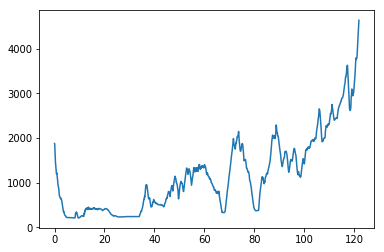

In [273]:
plt.plot( R*np.array( theta_span), ele_span )

In [274]:
# prise en compte courbure de la Terre
delta_ele = R*( 1- np.cos(theta_span[-1] / 2)/np.cos(theta_span - theta_span[-1] / 2) )*1e3

elevation_vue = np.array( ele_span )  + delta_ele

x = R*np.array( theta_span)
y = elevation_vue
ligne_de_vue = x*(y[-1]-y[0])/(x[-1]-x[0]) + y[0]

# test si visible

visible = ((ligne_de_vue - elevation_vue) > 0 ).all()

In [275]:
visible

True

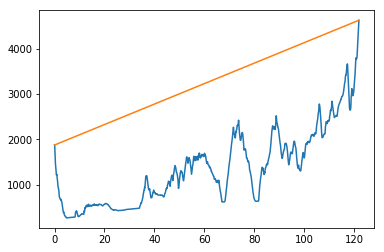

In [276]:
plt.plot( R*np.array( theta_span), elevation_vue )
plt.plot( R*np.array( theta_span), ligne_de_vue )

In [228]:
R*( 1/np.cos(theta) - 1 )*1e3

784.88561501530535